In [31]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [32]:
df = pd.read_csv('../WindFlow/data/newdata.csv')
df = df[['fecha', 'WDIR', 'WSPD', 'TEMP']]
df.head()

,fecha,WDIR,WSPD,TEMP
0,2019-12-31 20:01:00,252.392,6.27000,19.7667
1,2019-12-31 20:02:00,268.839,7.45833,20.0417
2,2019-12-31 20:03:00,278.251,8.05333,20.3000
3,2019-12-31 20:04:00,267.579,8.10667,20.1417
4,2019-12-31 20:05:00,268.002,5.89833,20.1500


In [33]:
df_5 = df[4::5]
df_5.head()

,fecha,WDIR,WSPD,TEMP
4,2019-12-31 20:05:00,268.002,5.89833,20.1500
9,2019-12-31 20:10:00,270.175,6.95083,20.3083
14,2019-12-31 20:15:00,269.000,6.89500,20.5750
19,2019-12-31 20:20:00,270.507,7.27083,20.8333
24,2019-12-31 20:25:00,270.682,9.22501,20.3000


In [34]:
date_time = pd.to_datetime(df.pop('fecha'))

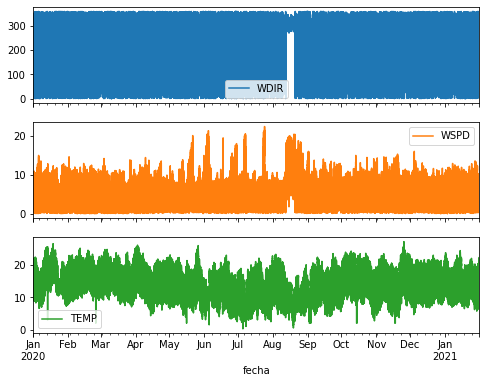

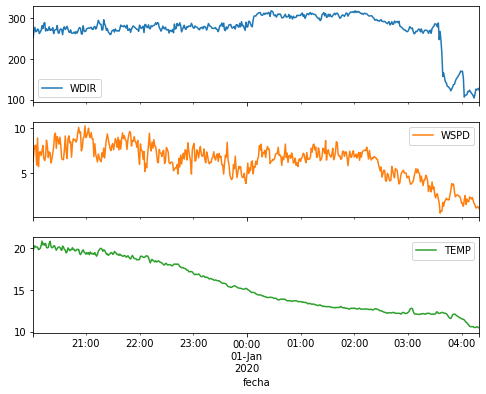

In [35]:
plot_cols = ['WDIR', 'WSPD', 'TEMP']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:500]
plot_features.index = date_time[:500]
_ = plot_features.plot(subplots=True)

In [36]:
df = df_5
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WDIR,114335.0,251.946651,70.155019,0.004753,255.47900,274.66700,286.96700,359.9970
WSPD,114335.0,4.958361,2.996900,0.062500,2.54417,4.72833,6.68667,21.8642
TEMP,114335.0,13.497780,4.800072,0.708333,9.64999,12.99170,17.62500,26.5333


Text(0, 0.5, 'Wind Velocity [m/s]')

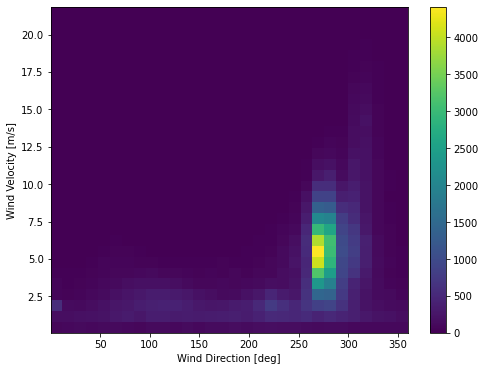

In [37]:
plt.hist2d(df['WDIR'], df['WSPD'], bins=(30, 30))
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [38]:
df = df.reset_index()
df.drop(columns=['index'], inplace = True)
df.head()

,fecha,WDIR,WSPD,TEMP
0,2019-12-31 20:05:00,268.002,5.89833,20.1500
1,2019-12-31 20:10:00,270.175,6.95083,20.3083
2,2019-12-31 20:15:00,269.000,6.89500,20.5750
3,2019-12-31 20:20:00,270.507,7.27083,20.8333
4,2019-12-31 20:25:00,270.682,9.22501,20.3000


In [39]:
wv = df['WSPD']

# Convert to radians.
wd_rad = df.pop('WDIR')*np.pi / 180
df['wd_rad'] = wd_rad
# Calculate the wind x and y components.
# df['Wx'] = wv*np.cos(wd_rad)
# df['Wy'] = wv*np.sin(wd_rad)
df['wd_cos'] = np.cos(wd_rad)
df['wd_sin'] = np.sin(wd_rad)

In [40]:
df.head()

,fecha,WSPD,TEMP,wd_rad,wd_cos,wd_sin
0,2019-12-31 20:05:00,5.89833,20.1500,4.677517,-0.034865,-0.999392
1,2019-12-31 20:10:00,6.95083,20.3083,4.715443,0.003054,-0.999995
2,2019-12-31 20:15:00,6.89500,20.5750,4.694936,-0.017452,-0.999848
3,2019-12-31 20:20:00,7.27083,20.8333,4.721238,0.008849,-0.999961
4,2019-12-31 20:25:00,9.22501,20.3000,4.724292,0.011903,-0.999929


(-1.0, 0.9999999986292216, -1.0, 0.9999999999619228)

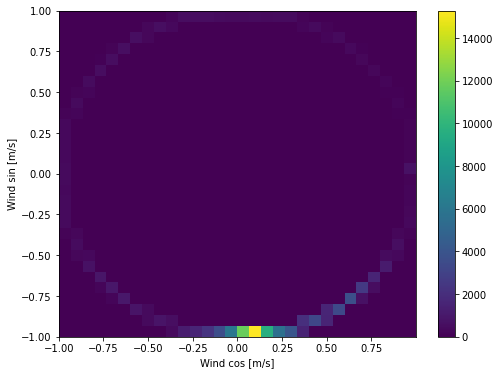

In [44]:
plt.hist2d(df['wd_cos'], df['wd_sin'], bins=(30, 30))
plt.colorbar()
plt.xlabel('Wind cos [m/s]')
plt.ylabel('Wind sin [m/s]')
ax = plt.gca()
ax.axis('tight')

In [45]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[0]

1577822460.0

In [46]:
day = 24*12*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

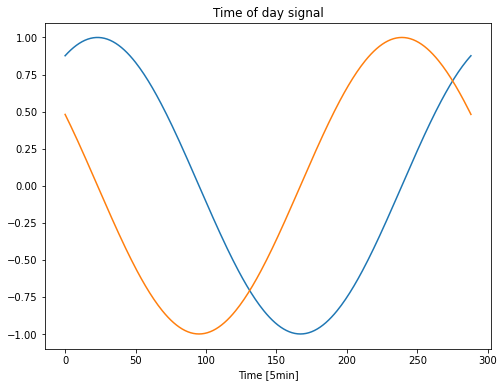

In [47]:
plt.plot(np.array(df['Day sin'])[:289])
plt.plot(np.array(df['Day cos'])[:289])
plt.xlabel('Time [5min]')
plt.title('Time of day signal')

In [48]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

10

In [49]:
# normalization

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_5455/4111471035.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = train_df.mean()
/tmp/ipykernel_5455/4111471035.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = train_df.std()


## Window class defined

In [51]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [52]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [53]:
def plot(self, model=None, plot_col='TEMP', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [54]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [55]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### def compile and fit

In [56]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [57]:
val_performance = {}
performance = {}

Total window size: 300
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

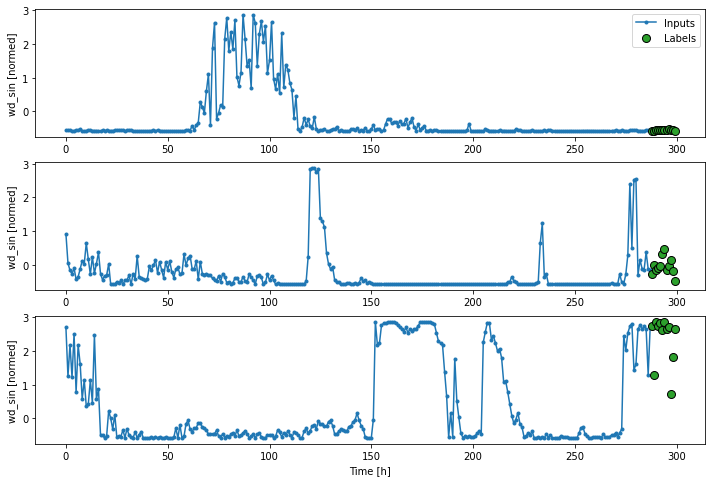

In [58]:
OUT_STEPS = 12
multi_window = WindowGenerator(input_width=288,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns= ['wd_cos', 'wd_sin'])

multi_window.plot(plot_col='wd_sin')
multi_window

In [59]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    #tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*2,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 2])
])

In [62]:
multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 288, 512)         546816    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 288, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
 reshape_1 (Reshape)         (None, 12, 2)             0         
                                                      

In [60]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/30
  34/2492 [..............................] - ETA: 1:14:59 - loss: nan - mean_absolute_error: nan

KeyboardInterrupt: 

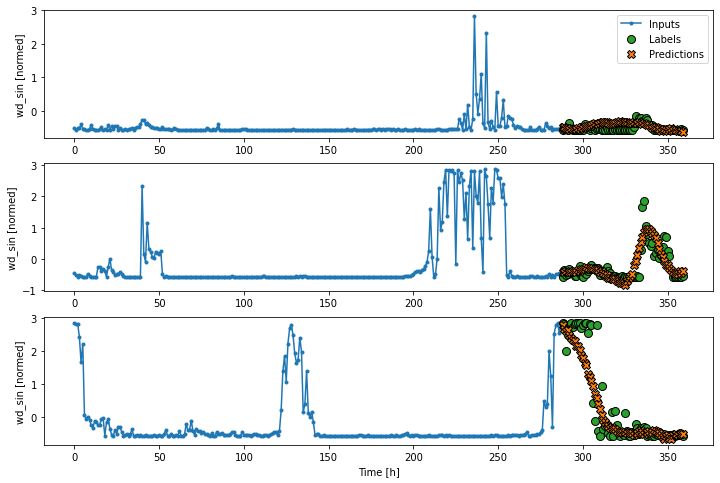

In [29]:
multi_window.plot(multi_lstm_model, plot_col = 'wd_sin')

In [32]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape)

Input shape: (32, 288, 11)
Output shape: (32, 72, 2)


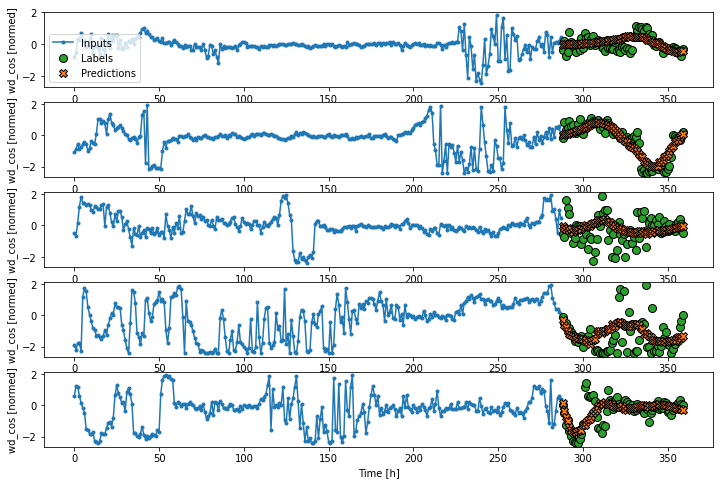

In [31]:
multi_window.plot(multi_lstm_model, plot_col = 'wd_cos', max_subplots = 5)